In [65]:
import requests
import datetime
import pandas as pd
import numpy as np
import time
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2OStackedEnsembleEstimator

In [66]:
def monitoring(url, params) : 
    h2o.init(ip="localhost", port=54323)
    responce = np.array(requests.get(url, params=params).json())
    while True:
        last = responce[-1, 8]
        responce = np.array(requests.get(url, params=params).json())
        print(last, responce[-1, 8])
        if last > responce[-1, 8]:
            df, testing = preprocessing(responce)
            res = train(df, testing)
            return res
        time.sleep(1)
        
url = 'https://api.binance.com/api/v3/klines'
params = {
  'symbol': 'BTCUSDT',
  'interval': '1m'
}
print(monitoring(url, params))

Checking whether there is an H2O instance running at http://localhost:54323. connected.


H2O_cluster_uptime:,4 mins 01 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,2 months and 19 days
H2O_cluster_name:,H2O_from_python_dolomone_b973gb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.970 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


150 150
150 221
221 230
230 248
248 292
292 301
301 309
309 313
313 323
323 393
393 410
410 430
430 448
448 506
506 517
517 528
528 549
549 559
559 579
579 587
587 595
595 605
605 611
611 614
614 622
622 640
640 645
645 653
653 660
660 667
667 692
692 757
757 843
843 848
848 854
854 882
882 897
897 908
908 15
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


H2OResponseError: Server error water.exceptions.H2OIllegalArgumentException:
  Error: Illegal argument: dir of function: importModel: water.api.FSIOException: FS IO Failure: 
 accessed path : file:/Users/dolomone/Documents/jupiters/StackedEnsemble_AllModels_1_AutoML_9_20240306_203111 msg: File not found
  Request: POST /99/Models.bin/
    data: {'dir': 'StackedEnsemble_AllModels_1_AutoML_9_20240306_203111'}


In [63]:
def preprocessing(responce):
    
#     Creating df
    df = pd.DataFrame(responce, columns = ['open_time','open_price','high_price', 'low_price','close_price','volume','close_time','quote_asset_volume','number_of_trades','taker_buy_base_asset_volume','taker_buy_quote_asset_volume', 'profit'])
    df = df.drop(columns = ['open_time', 'close_time', 'number_of_trades', 'profit'])
    data = np.array(df)
    
    #creating y values
    y = []
    for i in range(10, len(data)):
        y.append(data[i, 3])
    y.pop(-1)

    #creating main X data
    full_df = []
    for i in range(len(data)-10):
        row = []
        for j in data[i:i+10]:
            for el in j:
                row.append(el)
        full_df.append(row)
    testing = full_df.pop(-1)

#     Creating final df for trining
    df = pd.DataFrame(full_df)
    df['y'] = y
    return df, testing

In [61]:
def train(df, testing):
    h2o_df = h2o.H2OFrame(df)
    y = 'y'
    x = h2o_df.columns
    x.remove(y)
    stacked_ensemble_model = h2o.load_model("StackedEnsemble_AllModels_1_AutoML_9_20240306_203111")
    stacked_ensemble = H2OStackedEnsembleEstimator(model_id="my_stacked_ensemble")
    stacked_ensemble.train(x=train_data.columns, y=target_column)
    preds = stacked_ensemble.model_performance(testing)
    return preds

In [67]:
df = pd.DataFrame(responce, columns = ['open_time','open_price','high_price', 'low_price','close_price','volume','close_time','quote_asset_volume','number_of_trades','taker_buy_base_asset_volume','taker_buy_quote_asset_volume', 'profit'])
df = df.drop(columns = ['open_time', 'close_time', 'number_of_trades', 'profit'])
df

,open_price,high_price,low_price,close_price,volume,quote_asset_volume,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,69215.76000000,69234.28000000,69215.75000000,69234.28000000,5.63369000,389975.01979740,4.41033000,305291.19238420
1,69234.28000000,69272.05000000,69234.27000000,69272.04000000,12.96057000,897556.87730660,8.84207000,612345.63151890
2,69272.05000000,69281.10000000,69272.04000000,69272.89000000,12.34378000,855132.73676110,6.81210000,471915.30687440
3,69272.88000000,69279.99000000,69272.88000000,69279.99000000,12.10906000,838848.87336830,6.44549000,446510.35573220
4,69279.98000000,69296.03000000,69279.98000000,69289.10000000,13.24957000,918055.28420750,6.72566000,466000.32032880
...,...,...,...,...,...,...,...,...
495,69182.96000000,69219.21000000,69156.00000000,69169.55000000,34.79418000,2407410.97064700,21.59736000,1494306.16187830
496,69169.56000000,69169.56000000,69101.11000000,69131.79000000,35.20067000,2433292.02140940,19.38914000,1340210.81481040
497,69131.78000000,69173.99000000,69118.00000000,69173.58000000,24.97208000,1726884.35502180,16.02066000,1107834.66127130
498,69173.59000000,69173.99000000,69146.44000000,69163.57000000,16.87280000,1166956.31531190,9.54569000,660185.14341730


In [68]:
data = np.array(df)
data[0]

array(['69215.76000000', '69234.28000000', '69215.75000000',
       '69234.28000000', '5.63369000', '389975.01979740', '4.41033000',
       '305291.19238420'], dtype=object)

In [69]:
y = []
for i in range(10, len(data)):
    y.append(data[i, 3])
y.pop(-1)
print(len(y), y[-1])

489 69163.57000000


In [70]:
full_df = []
for i in range(len(data)-10):
    row = []
    for j in data[i:i+10]:
        for el in j:
            row.append(el)
    full_df.append(row)
testing = full_df.pop(-1)
print(len(full_df), full_df[0])

489 ['69215.76000000', '69234.28000000', '69215.75000000', '69234.28000000', '5.63369000', '389975.01979740', '4.41033000', '305291.19238420', '69234.28000000', '69272.05000000', '69234.27000000', '69272.04000000', '12.96057000', '897556.87730660', '8.84207000', '612345.63151890', '69272.05000000', '69281.10000000', '69272.04000000', '69272.89000000', '12.34378000', '855132.73676110', '6.81210000', '471915.30687440', '69272.88000000', '69279.99000000', '69272.88000000', '69279.99000000', '12.10906000', '838848.87336830', '6.44549000', '446510.35573220', '69279.98000000', '69296.03000000', '69279.98000000', '69289.10000000', '13.24957000', '918055.28420750', '6.72566000', '466000.32032880', '69289.10000000', '69293.47000000', '69289.09000000', '69293.46000000', '7.16474000', '496441.28511060', '3.40368000', '235838.96067990', '69293.47000000', '69300.00000000', '69293.46000000', '69297.52000000', '11.44149000', '792866.03028410', '7.09495000', '491660.86708940', '69297.53000000', '69304

In [71]:
df = pd.DataFrame(full_df)
df

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,69215.76000000,69234.28000000,69215.75000000,69234.28000000,5.63369000,389975.01979740,4.41033000,305291.19238420,69234.28000000,69272.05000000,...,1.33247000,92342.18951750,69300.00000000,69300.01000000,69295.77000000,69300.01000000,12.40598000,859707.57497740,5.70994000,395680.61113470
1,69234.28000000,69272.05000000,69234.27000000,69272.04000000,12.96057000,897556.87730660,8.84207000,612345.63151890,69272.05000000,69281.10000000,...,5.70994000,395680.61113470,69300.01000000,69300.01000000,69290.00000000,69290.01000000,5.92456000,410548.87493710,1.15553000,80072.72215930
2,69272.05000000,69281.10000000,69272.04000000,69272.89000000,12.34378000,855132.73676110,6.81210000,471915.30687440,69272.88000000,69279.99000000,...,1.15553000,80072.72215930,69290.00000000,69290.01000000,69210.00000000,69223.72000000,28.50528000,1974025.45042570,3.70561000,256560.51146730
3,69272.88000000,69279.99000000,69272.88000000,69279.99000000,12.10906000,838848.87336830,6.44549000,446510.35573220,69279.98000000,69296.03000000,...,3.70561000,256560.51146730,69223.71000000,69253.69000000,69206.15000000,69253.68000000,18.58871000,1286598.26786840,10.03499000,694574.05735230
4,69279.98000000,69296.03000000,69279.98000000,69289.10000000,13.24957000,918055.28420750,6.72566000,466000.32032880,69289.10000000,69293.47000000,...,10.03499000,694574.05735230,69253.68000000,69281.20000000,69253.68000000,69281.20000000,10.33816000,716113.38693750,6.65874000,461243.97672410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,69150.01000000,69163.19000000,68750.00000000,68914.00000000,275.55753000,18997722.55151680,93.81188000,6465606.90369280,68914.01000000,69044.43000000,...,33.50000000,2313016.85526250,69074.01000000,69197.89000000,69062.26000000,69197.89000000,43.83177000,3030264.53423160,22.25523000,1538443.12282750
485,68914.01000000,69044.43000000,68903.86000000,68989.53000000,104.99805000,7243561.98322960,50.40173000,3476798.73675610,68989.52000000,69008.00000000,...,22.25523000,1538443.12282750,69197.89000000,69239.93000000,69182.00000000,69182.95000000,44.35661000,3070108.40392620,19.36257000,1340023.57220600
486,68989.52000000,69008.00000000,68821.64000000,68891.98000000,112.43890000,7751998.42156120,70.89705000,4888522.10582060,68891.98000000,68892.93000000,...,19.36257000,1340023.57220600,69182.96000000,69219.21000000,69156.00000000,69169.55000000,34.79418000,2407410.97064700,21.59736000,1494306.16187830
487,68891.98000000,68892.93000000,68641.10000000,68716.35000000,175.67277000,12073669.03831020,81.29503000,5586592.19647230,68716.35000000,68888.70000000,...,21.59736000,1494306.16187830,69169.56000000,69169.56000000,69101.11000000,69131.79000000,35.20067000,2433292.02140940,19.38914000,1340210.81481040


In [72]:
df['y'] = y
df

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,y
0,69215.76000000,69234.28000000,69215.75000000,69234.28000000,5.63369000,389975.01979740,4.41033000,305291.19238420,69234.28000000,69272.05000000,...,92342.18951750,69300.00000000,69300.01000000,69295.77000000,69300.01000000,12.40598000,859707.57497740,5.70994000,395680.61113470,69290.01000000
1,69234.28000000,69272.05000000,69234.27000000,69272.04000000,12.96057000,897556.87730660,8.84207000,612345.63151890,69272.05000000,69281.10000000,...,395680.61113470,69300.01000000,69300.01000000,69290.00000000,69290.01000000,5.92456000,410548.87493710,1.15553000,80072.72215930,69223.72000000
2,69272.05000000,69281.10000000,69272.04000000,69272.89000000,12.34378000,855132.73676110,6.81210000,471915.30687440,69272.88000000,69279.99000000,...,80072.72215930,69290.00000000,69290.01000000,69210.00000000,69223.72000000,28.50528000,1974025.45042570,3.70561000,256560.51146730,69253.68000000
3,69272.88000000,69279.99000000,69272.88000000,69279.99000000,12.10906000,838848.87336830,6.44549000,446510.35573220,69279.98000000,69296.03000000,...,256560.51146730,69223.71000000,69253.69000000,69206.15000000,69253.68000000,18.58871000,1286598.26786840,10.03499000,694574.05735230,69281.20000000
4,69279.98000000,69296.03000000,69279.98000000,69289.10000000,13.24957000,918055.28420750,6.72566000,466000.32032880,69289.10000000,69293.47000000,...,694574.05735230,69253.68000000,69281.20000000,69253.68000000,69281.20000000,10.33816000,716113.38693750,6.65874000,461243.97672410,69246.98000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,69150.01000000,69163.19000000,68750.00000000,68914.00000000,275.55753000,18997722.55151680,93.81188000,6465606.90369280,68914.01000000,69044.43000000,...,2313016.85526250,69074.01000000,69197.89000000,69062.26000000,69197.89000000,43.83177000,3030264.53423160,22.25523000,1538443.12282750,69182.95000000
485,68914.01000000,69044.43000000,68903.86000000,68989.53000000,104.99805000,7243561.98322960,50.40173000,3476798.73675610,68989.52000000,69008.00000000,...,1538443.12282750,69197.89000000,69239.93000000,69182.00000000,69182.95000000,44.35661000,3070108.40392620,19.36257000,1340023.57220600,69169.55000000
486,68989.52000000,69008.00000000,68821.64000000,68891.98000000,112.43890000,7751998.42156120,70.89705000,4888522.10582060,68891.98000000,68892.93000000,...,1340023.57220600,69182.96000000,69219.21000000,69156.00000000,69169.55000000,34.79418000,2407410.97064700,21.59736000,1494306.16187830,69131.79000000
487,68891.98000000,68892.93000000,68641.10000000,68716.35000000,175.67277000,12073669.03831020,81.29503000,5586592.19647230,68716.35000000,68888.70000000,...,1494306.16187830,69169.56000000,69169.56000000,69101.11000000,69131.79000000,35.20067000,2433292.02140940,19.38914000,1340210.81481040,69173.58000000


In [73]:
import h2o
from h2o.automl import H2OAutoML

In [74]:
h2o.init(ip="localhost", port=54323)

Checking whether there is an H2O instance running at http://localhost:54323. connected.


H2O_cluster_uptime:,9 mins 10 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,2 months and 19 days
H2O_cluster_name:,H2O_from_python_dolomone_b973gb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.970 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [75]:
h2o_df = h2o.H2OFrame(df)
train_df, test_df, valid_df = h2o_df.split_frame(ratios = [.7,.15])
y = 'y'
x = h2o_df.columns
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [76]:
aml = H2OAutoML(max_models = 15, seed =42, verbosity = 'info', nfolds = 5)

In [77]:
aml.train(x = x, y = y, training_frame = train_df, validation_frame = valid_df)

AutoML progress: |
17:02:29.480: Project: AutoML_1_20240310_170229
17:02:29.481: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
17:02:29.481: Setting stopping tolerance adaptively based on the training frame: 0.05
17:02:29.481: Build control seed: 42
17:02:29.481: training frame: Frame key: AutoML_1_20240310_170229_training_py_2_sid_b978    cols: 81    rows: 357  chunks: 1    size: 150712  checksum: -8748465401951384152
17:02:29.481: validation frame: Frame key: py_4_sid_b978    cols: 81    rows: 76  chunks: 1    size: 37188  checksum: -3900050003182442466
17:02:29.481: leaderboard frame: NULL
17:02:29.481: blending frame: NULL
17:02:29.481: response column: y
17:02:29.481: fold column: null
17:02:29.481: weights column: null
17:02:29.488: AutoML: XGBoost is not available; skipp

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20240310_170229_model_2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    48                 48                          13081                  5            11           7.79167       14            19            17.0625

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 557.397880148153
RMSE: 23.609275299088555
MAE: 13.03107492997199
RMSLE: 0.00034110629222650166
Mean Residual Deviance: 557.397880148153

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 1685.1266111576804
RMSE: 41.050293679311
MAE: 30.472423014872078
RMSLE: 0.0005914079248639358
Mean Residual Deviance: 1685.1266111576804

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 2344.3986780450928
RMSE: 48.418990882143476
MAE: 33.04556864677514
RMSLE: 0.0006978693209079174
Mean Residual Deviance: 2344.3986780450928

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     33.0051      3.58813      38.2104       30.9921       32.1078       34.7656       28.9495
mean_residual_deviance  2367.25      681.654      2848.55       1760.1        2451.12       3178.94       1597.54
mse                     2367.25      681.654      2848.55       1760.1        2451.12       3178.94       1597.54
r2                      0.942335     0.0159467    0.931581      0.957538      0.936092      0.925486      0.960977
residual_deviance       2367.25      681.654      2848.55       1760.1        2451.12       3178.94       1597.54
rmse                    48.2371      7.10922      53.3718       41.9535       49.5088       56.3821       39.9692
rmsle                   0.000695118  0.000103202  0.00076821    0.000603917   0.000714392   0.000814057   0.000575016

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance    validation_rmse    validation_mae    validation_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------  -----------------  ----------------  ---------------------
    2024-03-10 17:02:36  1.283 sec   0                  202.625          169.714         41057.1              200.811            163.973           40325
    2024-03-10 17:02:36  1.301 sec   5                  124.94           101.903         15609.9              128.07             100.698           16402
    2024-03-10 17:02:36  1.317 sec   10                 80.7891          62.2553         6526.87              86.5303            64.211            7487.5
    2024-03-10 17:02:36  1.332 sec   15                 57.6065          40.7177         3318.51              65.1565            46.1306           4245.37
    2024-03-10 17:02:36  1.348 sec   20                 44.8325          29.1809         2009.96              54.768             38.3383           2999.53
    2024-03-10 17:02:36  1.363 sec   25                 36.0257          22.8242         1297.85              46.3854            33.6191           2151.61
    2024-03-10 17:02:36  1.378 sec   30                 31.4906          18.8623         991.658              43.6088            31.3157           1901.73
    2024-03-10 17:02:36  1.393 sec   35                 28.3099          16.5123         801.451              41.809             30.4982           1748
    2024-03-10 17:02:36  1.410 sec   40                 26.5575          14.7876         705.3   

In [78]:
lb = aml.leaderboard
lb.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_1_20240310_170229_model_2,48.419,2344.4,33.0456,0.000697869,2344.4
GBM_5_AutoML_1_20240310_170229,48.8256,2383.94,32.7125,0.000703519,2383.94
GBM_grid_1_AutoML_1_20240310_170229_model_1,48.9387,2395,33.5438,0.000705098,2395
GBM_4_AutoML_1_20240310_170229,48.9938,2400.39,33.513,0.000706093,2400.39
DRF_1_AutoML_1_20240310_170229,49.9347,2493.48,34.2406,0.000719603,2493.48
GBM_3_AutoML_1_20240310_170229,49.9601,2496.01,33.6392,0.000720111,2496.01
XRT_1_AutoML_1_20240310_170229,49.9602,2496.02,33.5066,0.000719978,2496.02
GBM_2_AutoML_1_20240310_170229,50.0763,2507.64,34.5411,0.000721754,2507.64
GBM_grid_1_AutoML_1_20240310_170229_model_3,50.795,2580.14,35.4721,0.000731791,2580.14
DeepLearning_grid_3_AutoML_1_20240310_170229_model_1,63.4348,4023.97,46.2312,0.000913371,4023.97


In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
test_df = h2o.H2OFrame(test_df)
preds = aml.leader.predict(test_df)
test_df = test_df.as_data_frame()
preds = preds.as_data_frame()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/dolomone/.local/lib/python3.11/site-packages/h2o/frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/dolomone/.local/lib/python3.11/site-packages/h2o/frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


<Axes: ylabel='y'>

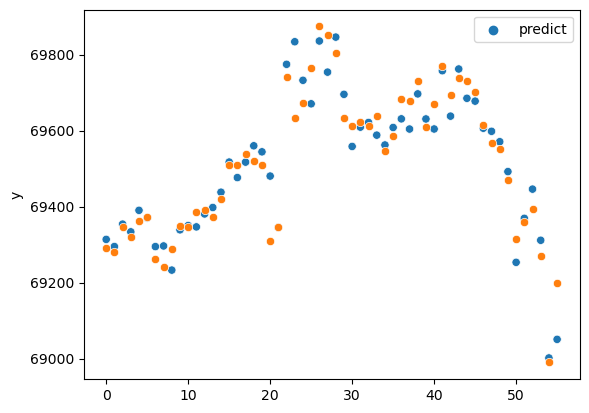

In [81]:
sns.scatterplot(preds)
sns.scatterplot(test_df.y)

In [83]:
testing = h2o.H2OFrame(test_df)
pred = aml.leader.predict(testing)
pred

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
69313.5
69294.7
69353.7
69333.4
69390
69370
69294.6
69296.3
69232.7
69338.7


<Axes: ylabel='y'>

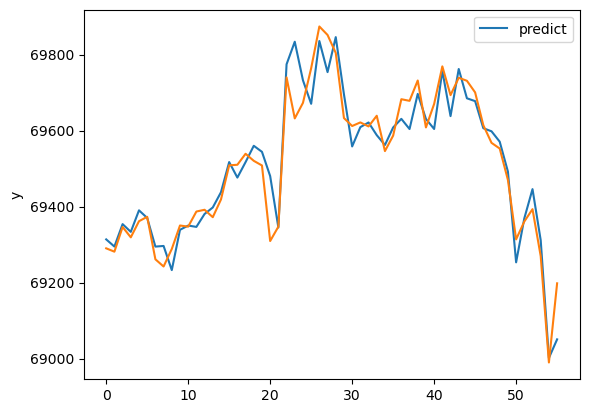

In [84]:
sns.lineplot(preds)
sns.lineplot(test_df.y)

In [293]:
train_df

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,y
67997.2,68016.9,67782.6,67812,237.535,1.61246e+07,110.786,7.5211e+06,67812,67888,67767.8,67852.4,205.283,1.39241e+07,82.8426,5.61943e+06,67852.4,68167.7,67847.5,68167.6,220.265,1.49924e+07,120.621,8.20829e+06,68167.6,68171.6,67916.8,67930,176.579,1.20224e+07,85.6909,5.83354e+06,67930,68114.7,67920.7,67993.4,149.612,1.01788e+07,66.3092,4.51127e+06,67993.4,68100,67987.5,68034,201.586,1.37157e+07,111.633,7.59471e+06,68034,68230.1,67981.1,68230.1,210.34,1.43216e+07,94.3749,6.42675e+06,68230.1,68346.5,68021.5,68321.5,299.042,2.03993e+07,145.139,9.89959e+06,68321.5,68492.6,68314,68337.4,433.034,2.96212e+07,247.743,1.69469e+07,68337.4,68500,68200,68262.7,391.679,2.68004e+07,198.084,1.35549e+07,68478
67930,68114.7,67920.7,67993.4,149.612,1.01788e+07,66.3092,4.51127e+06,67993.4,68100,67987.5,68034,201.586,1.37157e+07,111.633,7.59471e+06,68034,68230.1,67981.1,68230.1,210.34,1.43216e+07,94.3749,6.42675e+06,68230.1,68346.5,68021.5,68321.5,299.042,2.03993e+07,145.139,9.89959e+06,68321.5,68492.6,68314,68337.4,433.034,2.96212e+07,247.743,1.69469e+07,68337.4,68500,68200,68262.7,391.679,2.68004e+07,198.084,1.35549e+07,68262.7,68500,68191.1,68478,326.214,2.23168e+07,185.475,1.26903e+07,68478,68489.7,68345.3,68415.8,175.038,1.19742e+07,92.3099,6.31473e+06,68415.8,68439.2,68272.6,68284.9,174.739,1.19461e+07,82.9145,5.66843e+06,68284.9,68322.6,68055.9,68322.6,273.802,1.86748e+07,105.264,7.1793e+06,68273
67993.4,68100,67987.5,68034,201.586,1.37157e+07,111.633,7.59471e+06,68034,68230.1,67981.1,68230.1,210.34,1.43216e+07,94.3749,6.42675e+06,68230.1,68346.5,68021.5,68321.5,299.042,2.03993e+07,145.139,9.89959e+06,68321.5,68492.6,68314,68337.4,433.034,2.96212e+07,247.743,1.69469e+07,68337.4,68500,68200,68262.7,391.679,2.68004e+07,198.084,1.35549e+07,68262.7,68500,68191.1,68478,326.214,2.23168e+07,185.475,1.26903e+07,68478,68489.7,68345.3,68415.8,175.038,1.19742e+07,92.3099,6.31473e+06,68415.8,68439.2,68272.6,68284.9,174.739,1.19461e+07,82.9145,5.66843e+06,68284.9,68322.6,68055.9,68322.6,273.802,1.86748e+07,105.264,7.1793e+06,68322.6,68400,68273,68273,146.294,9.99772e+06,76.8857,5.25399e+06,68569.3
68034,68230.1,67981.1,68230.1,210.34,1.43216e+07,94.3749,6.42675e+06,68230.1,68346.5,68021.5,68321.5,299.042,2.03993e+07,145.139,9.89959e+06,68321.5,68492.6,68314,68337.4,433.034,2.96212e+07,247.743,1.69469e+07,68337.4,68500,68200,68262.7,391.679,2.68004e+07,198.084,1.35549e+07,68262.7,68500,68191.1,68478,326.214,2.23168e+07,185.475,1.26903e+07,68478,68489.7,68345.3,68415.8,175.038,1.19742e+07,92.3099,6.31473e+06,68415.8,68439.2,68272.6,68284.9,174.739,1.19461e+07,82.9145,5.66843e+06,68284.9,68322.6,68055.9,68322.6,273.802,1.86748e+07,105.264,7.1793e+06,68322.6,68400,68273,68273,146.294,9.99772e+06,76.8857,5.25399e+06,68273,68580,68244.3,68569.3,363.974,2.49217e+07,263.429,1.8039e+07,68656.3
68230.1,68346.5,68021.5,68321.5,299.042,2.03993e+07,145.139,9.89959e+06,68321.5,68492.6,68314,68337.4,433.034,2.96212e+07,247.743,1.69469e+07,68337.4,68500,68200,68262.7,391.679,2.68004e+07,198.084,1.35549e+07,68262.7,68500,68191.1,68478,326.214,2.23168e+07,185.475,1.26903e+07,68478,68489.7,68345.3,68415.8,175.038,1.19742e+07,92.3099,6.31473e+06,68415.8,68439.2,68272.6,68284.9,174.739,1.19461e+07,82.9145,5.66843e+06,68284.9,68322.6,68055.9,68322.6,273.802,1.86748e+07,105.264,7.1793e+06,68322.6,68400,68273,68273,146.294,9.99772e+06,76.8857,5.25399e+06,68273,68580,68244.3,68569.3,363.974,2.49217e+07,263.429,1.8039e+07,68569.3,68686.8,68451.1,68656.3,395.08,2.71038e+07,254.794,1.74789e+07,68506
68321.5,68492.6,68314,68337.4,433.034,2.96212e+07,247.743,1.69469e+07,68337.4,68500,68200,68262.7,391.679,2.68004e+07,198.084,1.35549e+07,68262.7,68500,68191.1,68478,326.214,2.23168e+07,185.475,1.26903e+07,68478,68489.7,68345.3,68415.8,175.038,1.19742e+07,92

In [301]:
testing = np.array(testing)

In [302]:
testind_df = pd.DataFrame(testing)

In [305]:
testind_df = testind_df.T

In [309]:
testind_df = testind_df.drop(columns = 80)

In [310]:
testind_df['y'] = 0

In [311]:
testind_df

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,y
0,66941.10000000,67093.27000000,66921.11000000,67001.56000000,179.36030000,12022438.79642140,72.36171000,4849577.29562210,67001.55000000,67090.00000000,...,9965628.63934030,67085.42000000,67347.00000000,67074.16000000,67324.84000000,251.40050000,16897918.81805590,149.74961000,10066935.23147140,0
